# Integrating Visium data

This tutorial including loading, preprocessing, DAVAE integration and visualization of spatial scRNA-seq data.
We first integrate [Anterior](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.1.0/V1_Mouse_Brain_Sagittal_Anterior) and [Posterior](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.1.0/V1_Mouse_Brain_Sagittal_Posterior) mouse brain 10x Genomics Visium data in this tutorial. 
We then integrate mouse brain visium data with scRNA-seq data.

For more detailed tutorial of Visium data, please refer to [scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/integration-scanorama.html).


### Importing scbean package
Here, we'll import scbean along with other popular packages.

In [1]:
import scbean.model.davae as davae
from scbean.tools import utils as tl
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
from numpy.random import seed
seed(2021)
matplotlib.use('TkAgg')

# Command for Jupyter notebooks only
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

## DAVAE integration of two spatial gene expression data
### Loading data

In [2]:
base_path = '/Users/zhongyuanke/data/'
file1_spatial = base_path+'spatial/mouse_brain/10x_mouse_brain_Anterior/'
file2_spatial = base_path+'spatial/mouse_brain/10x_mouse_brain_Posterior/'
file1 = base_path+'spatial/mouse_brain/10x_mouse_brain_Anterior/V1_Mouse_Brain_Sagittal_Anterior_filtered_feature_bc_matrix.h5'
file2 = base_path+'spatial/mouse_brain/10x_mouse_brain_Posterior/V1_Mouse_Brain_Sagittal_Posterior_filtered_feature_bc_matrix.h5'

adata_spatial_anterior = sc.read_visium(file1_spatial, count_file=file1)
adata_spatial_posterior = sc.read_visium(file2_spatial, count_file=file2)
adata_spatial_anterior.var_names_make_unique()
adata_spatial_posterior.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
adata_spatial_anterior

AnnData object with n_obs × n_vars = 2695 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

### Data preprocessing
Here, we filter and normalize each dataset separately and concatenate them into one AnnData object. For more details, please check the preprocessing [API]().

In [4]:
adata_spatial = tl.spatial_preprocessing([adata_spatial_anterior, adata_spatial_posterior])

### DAVAE integration 
The code for integration using davae is as following:

In [5]:
adata_integrate = davae.fit_integration(
    adata_spatial,
    epochs=25,
    split_by='loss_weight',
    hidden_layers=[128, 64, 32, 5],
    sparse=True,
    domain_lambda=0.5,
)
adata_spatial.obsm["X_davae"] = adata_integrate.obsm['X_davae']

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 32285)]      0                                            
__________________________________________________________________________________________________
inputs_batch (InputLayer)       [(None, 2)]          0                                            
__________________________________________________________________________________________________
encoder_hx (Functional)         [(None, 5), (None, 5 4144202     inputs[0][0]                     
                                                                 inputs_batch[0][0]               
                                                                 inputs[0][0]                     
                                                                 inputs_batch[0][0]         

48/48 [==============================] - 9s 133ms/step - loss: -386908.5975
Epoch 2/25
48/48 [==============================] - 6s 133ms/step - loss: -568583.4847
Epoch 3/25
48/48 [==============================] - 6s 133ms/step - loss: -571450.0421
Epoch 4/25
48/48 [==============================] - 6s 132ms/step - loss: -582320.7781
Epoch 5/25
48/48 [==============================] - 6s 132ms/step - loss: -574299.7755
Epoch 6/25
48/48 [==============================] - ETA: 0s - loss: -581766.251 - 6s 133ms/step - loss: -581928.7526
Epoch 7/25
48/48 [==============================] - 6s 133ms/step - loss: -589077.8367
Epoch 8/25
48/48 [==============================] - 6s 132ms/step - loss: -591216.1263
Epoch 9/25
48/48 [==============================] - 6s 133ms/step - loss: -594757.7474
Epoch 10/25
48/48 [==============================] - 6s 132ms/step - loss: -600397.4732
Epoch 11/25
48/48 [==============================] - 6s 132ms/step - loss: -598819.6467
Epoch 12/25
48/48 [===

The embedding representation from vipcca of each cell have been saved in adata.obsm('X_davae')

In [6]:
adata_spatial

AnnData object with n_obs × n_vars = 6050 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'loss_weight', 'library_id'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable-V1_Mouse_Brain_Sagittal_Anterior', 'means-V1_Mouse_Brain_Sagittal_Anterior', 'dispersions-V1_Mouse_Brain_Sagittal_Anterior', 'dispersions_norm-V1_Mouse_Brain_Sagittal_Anterior', 'highly_variable-V1_Mouse_Brain_Sagittal_Posterior', 'means-V1_Mouse_Brain_Sagittal_Posterior', 'dispersions-V1_Mouse_Brain_Sagittal_Posterior', 'dispersions_norm-V1_Mouse_Brain_Sagittal_Posterior'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial', 'X_davae'

### UMAP visualization and clustering
We use UMAP to reduce the embedding feature output by DAVAE in 2 dimensions.

... storing 'feature_types' as categorical
... storing 'genome' as categorical


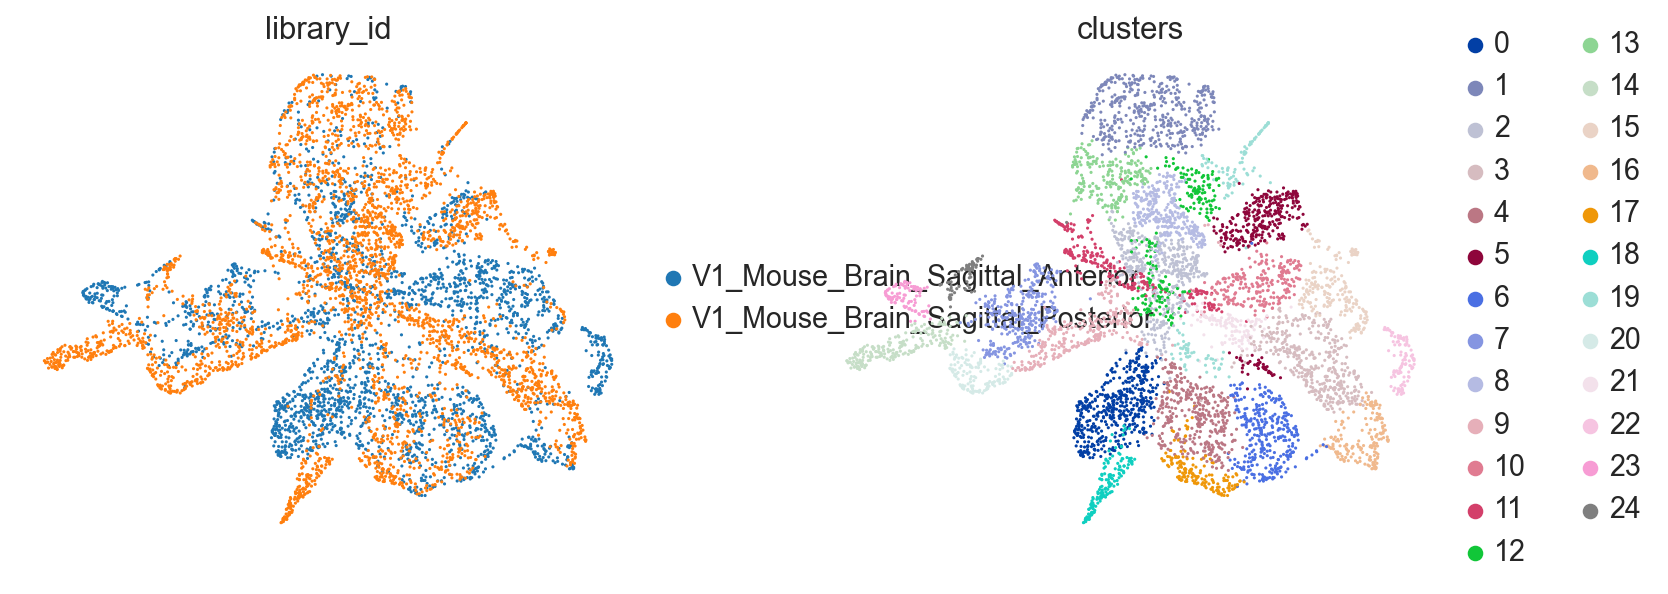

In [7]:
sc.set_figure_params(facecolor="white", figsize=(5, 4))
sc.pp.neighbors(adata_spatial, use_rep='X_davae', n_neighbors=12)
sc.tl.umap(adata_spatial)
sc.tl.louvain(adata_spatial, key_added="clusters")
sc.pl.umap(adata_spatial, color=['library_id', "clusters"],
           size=8, color_map='Set2', frameon=False)

### Visualization in spatial coordinates
For more detailed usage of Visium data visualization, please refer to [sc.pl.spatial()](https://scanpy.readthedocs.io/en/latest/api/scanpy.pl.spatial.html) function.

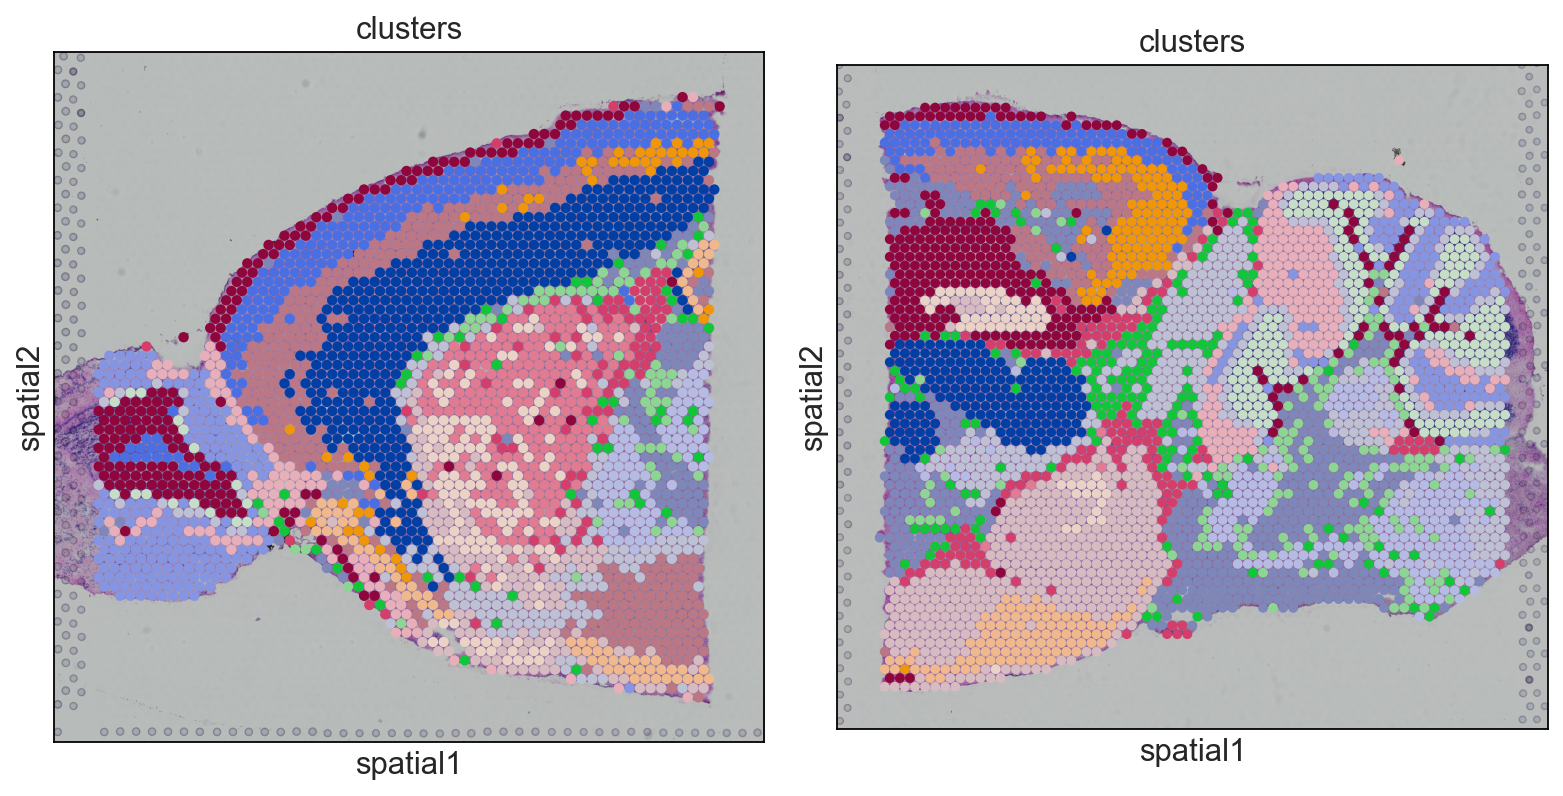

In [8]:
clusters_colors = dict(
    zip([str(i) for i in range(18)], adata_spatial.uns["clusters_colors"])
)
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

for i, library in enumerate(
    ["V1_Mouse_Brain_Sagittal_Anterior", "V1_Mouse_Brain_Sagittal_Posterior"]
):
    ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color="clusters",
        size=1.5,
        palette=[
            v
            for k, v in clusters_colors.items()
            if k in ad.obs.clusters.unique().tolist()
        ],
        legend_loc=None,
        show=False,
        ax=axs[i],
    )

plt.tight_layout()
plt.show()

## DAVAE integration of spatial gene expression and scRNA-seq data
Followed by [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/integration-scanorama.html), this tutorial also performs data integration on the scRNA-seq dataset and a spatial transcriptomics dataset. This task allows us to transfer the cell type labels identified from the scRNA-seq data set to the Visium data set.


### Import additional package
Here, we'll import additional packages other than the package imported at the beginning

In [9]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

### Loading data
The dataset can be downloaded from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE115746). Conveniently, you can also download the pre-processed dataset in h5ad format from [here](https://hmgubox.helmholtz-muenchen.de/f/4ef254675e2a41f89835/?dl=1).


**load scRNA-seq dataset**

In [10]:
base_path = '/Users/zhongyuanke/data/'
file_rna = base_path+'spatial/mouse_brain/adata_processed_sc.h5ad'
adata_rna = sc.read_h5ad(file_rna)

**load visium dataset**

In [11]:
file1 = base_path+'spatial/mouse_brain/10x_mouse_brain_Anterior/V1_Mouse_Brain_Sagittal_Anterior_filtered_feature_bc_matrix.h5'
file1_spatial = base_path+'spatial/mouse_brain/10x_mouse_brain_Anterior/'
adata_spatial_anterior = sc.read_visium(file1_spatial, count_file=file1)
adata_spatial_anterior.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Preprocessing
For more detailed usage, please refer to [api]().

In [12]:
adata_all = tl.spatial_rna_preprocessing(
    adata_spatial_anterior,
    adata_rna,
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


### DAVAE integration

In [13]:
adata_integrate = davae.fit_integration(
    adata_all,
    epochs=28,
    batch_size=128,
    domain_lambda=3.0,
    sparse=True,
    hidden_layers=[64, 32, 5]
)

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 3225)]       0                                            
__________________________________________________________________________________________________
inputs_batch (InputLayer)       [(None, 2)]          0                                            
__________________________________________________________________________________________________
encoder_hx (Functional)         [(None, 5), (None, 5 209290      inputs[0][0]                     
                                                                 inputs_batch[0][0]               
                                                                 inputs[0][0]                     
                                                                 inputs_batch[0][0]         

196/196 [==============================] - 4s 10ms/step - loss: -7588.9892
Epoch 2/28
196/196 [==============================] - 2s 10ms/step - loss: -13737.7835
Epoch 3/28
196/196 [==============================] - 2s 10ms/step - loss: -16087.3696
Epoch 4/28
196/196 [==============================] - 2s 10ms/step - loss: -16931.1400
Epoch 5/28
196/196 [==============================] - 2s 10ms/step - loss: -17309.1250
Epoch 6/28
196/196 [==============================] - 2s 10ms/step - loss: -17901.8325
Epoch 7/28
196/196 [==============================] - 2s 10ms/step - loss: -18129.4123
Epoch 8/28
196/196 [==============================] - 2s 10ms/step - loss: -18482.4152
Epoch 9/28
196/196 [==============================] - 2s 10ms/step - loss: -18412.7074
Epoch 10/28
196/196 [==============================] - 2s 10ms/step - loss: -18661.8825
Epoch 11/28
196/196 [==============================] - 2s 10ms/step - loss: -18811.8410
Epoch 12/28
196/196 [==============================] 

### Calculate distance

In [14]:
len_anterior = adata_spatial_anterior.shape[0]
len_rna = adata_rna.shape[0]
davae_emb = adata_integrate.obsm['X_davae']

adata_spatial_anterior.obsm["davae_embedding"] = davae_emb[0:len_anterior, :]
adata_rna.obsm['davae_embedding'] = davae_emb[len_anterior:len_rna+len_anterior, :]

distances_anterior = 1 - cosine_distances(
    adata_rna.obsm["davae_embedding"],
    adata_spatial_anterior.obsm['davae_embedding'],
)

### Transfer label

In [15]:
def label_transfer(dist, labels):
    lab = pd.get_dummies(labels).to_numpy().T
    class_prob = lab @ dist
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    return class_prob

class_prob_anterior = label_transfer(distances_anterior, adata_rna.obs.cell_subclass)
cp_anterior_df = pd.DataFrame(
    class_prob_anterior, 
    columns=np.sort(adata_rna.obs.cell_subclass.unique())
)
cp_anterior_df.index = adata_spatial_anterior.obs.index
adata_anterior_transfer = adata_spatial_anterior.copy()
adata_anterior_transfer.obs = pd.concat(
    [adata_spatial_anterior.obs, cp_anterior_df], 
    axis=1
)

### Visualize the neurons cortical layers

... storing 'feature_types' as categorical
... storing 'genome' as categorical


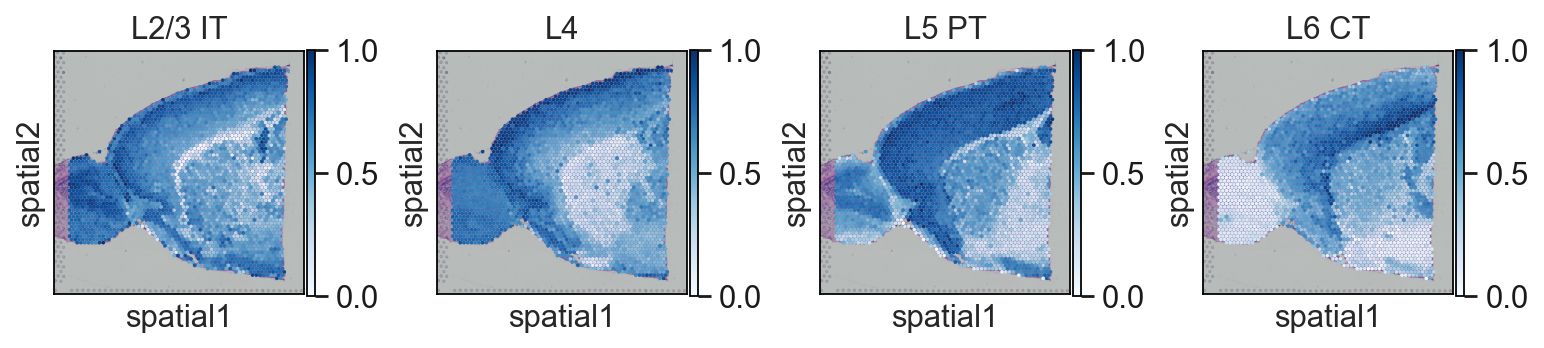

In [16]:
sc.set_figure_params(facecolor="white", figsize=(2, 2))
sc.pl.spatial(
    adata_anterior_transfer,
    img_key="hires",
    color=["L2/3 IT", "L4", "L5 PT", "L6 CT"],
    size=1.5,
    color_map='Blues',
)